In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/CZ4042')

# **Part A: Classification**

In [ ]:
import time
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler, Callback


In [ ]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

## **Preprocessing Data**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CZ4042/full.csv') 
df['label'] = df['filename'].str.split('_').str[-2]
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,label
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803,neg
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572,neg
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824,neg
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389,neg
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966,neg


In [ ]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

## **Split and scale dataset**

In [ ]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, Y_train, X_test, Y_test = split_dataset(df, columns_to_drop, test_size=0.2, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

Similarly to question 2, we decide to split training-validation set and test set with ratio 80:20.

# **Q3**

**Find the optimal number of hidden neurons for first hidden layer of the 5-layer network (input
layer, 3 hidden layers, output layer) designed in Question 1 and 2.**


In [ ]:
# input to perform cross-validation
X = np.array(X_train_scaled)
Y = np.array(Y_train)

####**a) Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.**

In [ ]:
l_r = 0.001
epochs = 100
drop_out = 0.2
no_folds = 5
batch_size = 512
hidden_units =[64, 128, 256]


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In this question, the k-fold will be executed a little different from choosing batch size experiment. We follow the lecture notebook, instead of running all 5 folds for each batch size and compute the mean accuracy, we will run each fold and examine all hidden units and calculate the mean accuracy at the end of training 5-fold. 

In [ ]:
test_acc = []
train_acc=[]
def train_exp(X,Y):
    acc = []
    cv = KFold(n_splits=no_folds, shuffle=True, random_state=1)
    fold = 0
    
    for train_idx, test_idx in cv.split(X,Y):
        acc_ = []
        x_train, y_train  = X[train_idx], Y[train_idx]
        x_test, y_test = X[test_idx], Y[test_idx]
        print(f'Training for fold {fold+1} ...')
        for num_neurons in hidden_units:
            print("----- NUM NEURONS: %d -----" %num_neurons)
            model = keras.Sequential([
                    Dense(num_neurons, activation='relu'),
                    Dropout(drop_out),
                    Dense(num_neurons, activation='relu'),
                    Dropout(drop_out),
                    Dense(num_neurons, activation='relu'),
                    Dropout(drop_out),
                    Dense(1, activation='sigmoid')])
          
            opt = keras.optimizers.Adam(l_r)
            model.compile(optimizer=opt,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
            
            history = model.fit(x_train, y_train,
                                epochs=epochs,
                                verbose=0,
                                use_multiprocessing=True,
                                batch_size = batch_size,
                                callbacks = [early_stopping],
                                validation_data=(x_test, y_test))

            # Save the validation accuracy and loss for last epoch each fold to compute the mean value to evaluate
            val_acc = history.history['val_binary_accuracy']
            val_loss = history.history['val_loss']

            acc_.append(val_acc[-1])
            test_acc.append(val_acc)
            train_acc.append(history.history['binary_accuracy'])

            # Log the results
            print('Fold %d: model loss - %.3f; model accuracy - %.2f' %(fold+1, val_loss[-1], val_acc[-1]*100))    
            
        acc.append(acc_)
        fold += 1
        print('------------------------------------------------------------------------')
    cv_acc = np.mean(np.array(acc), axis = 0)

    return cv_acc

We perform the expriment 3 times to find the most optimal number of hidden_unit. It is suggested that repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model. We will report the mean result across all folds from all runs [1]. 

In [ ]:
acc = []
no_exps = 3
# Repeat everything for 3 times 
for exp in range(no_exps):
    acc.append(train_exp(X,Y))
    print('exp %d, cv acc %s'%(exp, acc[exp]))

mean_acc = np.mean(np.array(acc), axis = 0)
print('The mean accuracy for each hidden_units: %s'%(mean_acc))
print('* The best hidden units: %d *'%hidden_units[np.argmax(mean_acc)])

Training for fold 1 ...
----- NUM NEURONS: 64 -----
Fold 1: model loss - 0.648; model accuracy - 61.78
----- NUM NEURONS: 128 -----
Fold 1: model loss - 0.600; model accuracy - 66.46
----- NUM NEURONS: 256 -----
Fold 1: model loss - 0.559; model accuracy - 70.71
------------------------------------------------------------------------
Training for fold 2 ...
----- NUM NEURONS: 64 -----
Fold 2: model loss - 0.654; model accuracy - 60.46
----- NUM NEURONS: 128 -----
Fold 2: model loss - 0.611; model accuracy - 65.53
----- NUM NEURONS: 256 -----
Fold 2: model loss - 0.564; model accuracy - 70.52
------------------------------------------------------------------------
Training for fold 3 ...
----- NUM NEURONS: 64 -----
Fold 3: model loss - 0.647; model accuracy - 61.76
----- NUM NEURONS: 128 -----
Fold 3: model loss - 0.602; model accuracy - 66.74
----- NUM NEURONS: 256 -----
Fold 3: model loss - 0.554; model accuracy - 71.27
-----------------------------------------------------------------

Text(0, 0.5, 'mean CV accuracy')

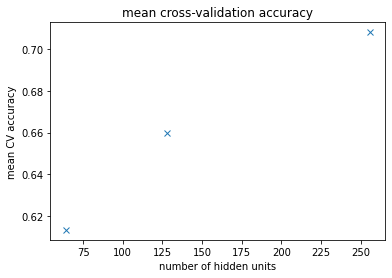

In [ ]:
plt.figure(1)
plt.plot(hidden_units, mean_acc, marker = 'x', linestyle = 'None')
plt.title('mean cross-validation accuracy')
plt.xlabel('number of hidden units')
plt.ylabel('mean CV accuracy')

####**b) Select the optimal number of neurons for the hidden layer. State the rationale for your selection.**

Based on the accuracy of the model, we will use 256 as the optimal number of neurons for the hidden layers. The mean CV accuracy of 256-hidden-unit model outperforms the others. Below is a visualization of how the mean CV accuracy change per fold and epoch for each hidden unit candidate.

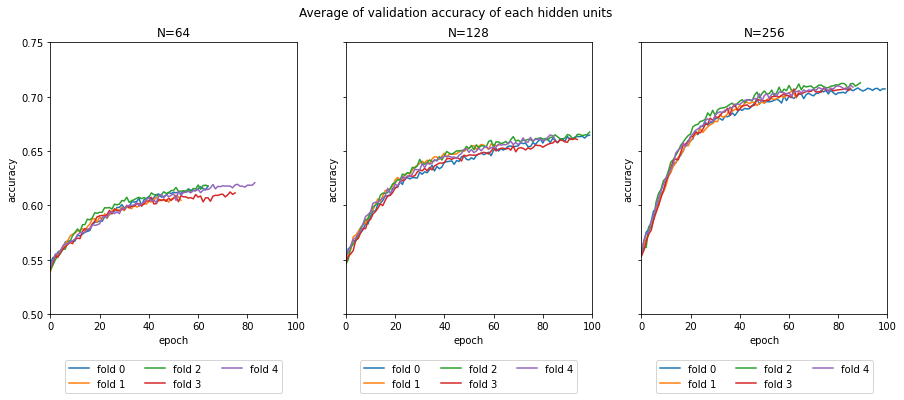

In [ ]:
fig,axs = plt.subplots(1,3, sharey = True, figsize=(15, 5))
fig.suptitle('Average of validation accuracy of each hidden units')

for n in range(len(hidden_units)):
    axs[n].axis([0, 100, 0.500, 0.750])
    axs[n].set_title("N=%d"%(hidden_units[n]))
    axs[n].margins(0.05) 
    axs[n].plot(test_acc[n], label='fold 0')
    axs[n].plot(test_acc[n+3], label='fold 1')
    axs[n].plot(test_acc[n+6], label='fold 2')
    axs[n].plot(test_acc[n+9], label='fold 3')  
    axs[n].plot(test_acc[n+12], label='fold 4')    
    
    axs[n].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    axs[n].set_ylabel('accuracy')
    axs[n].set_xlabel('epoch')


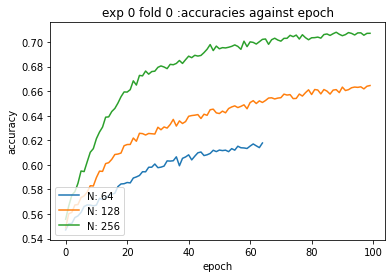

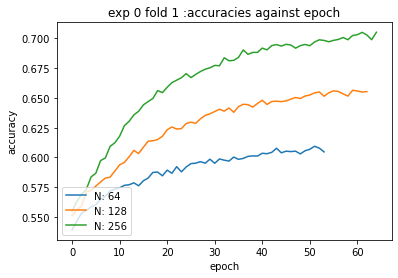

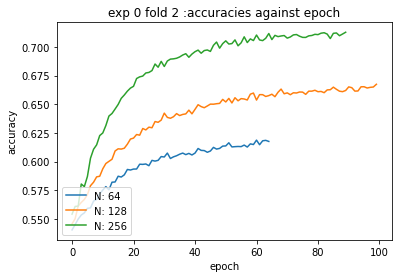

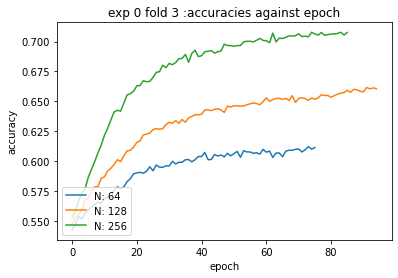

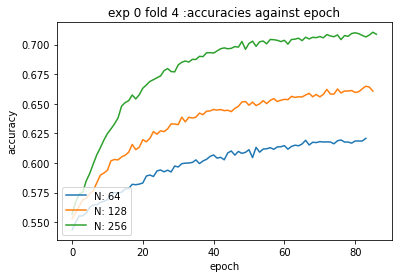

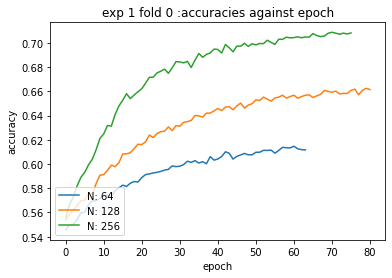

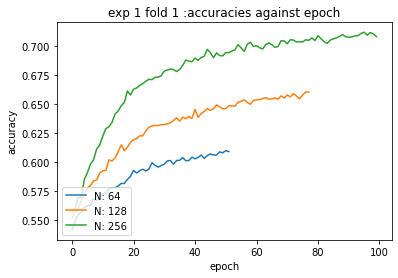

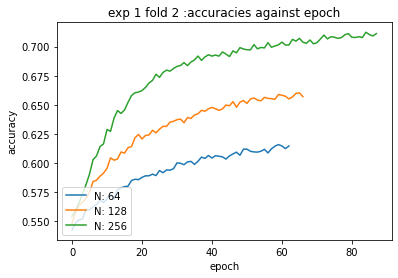

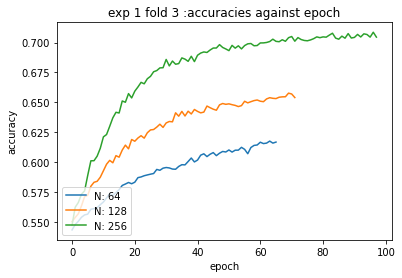

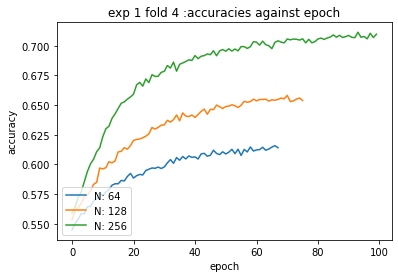

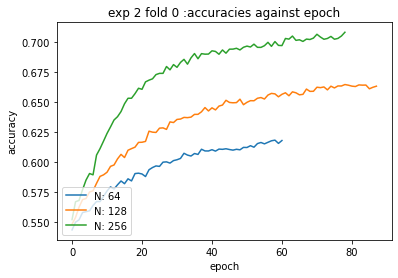

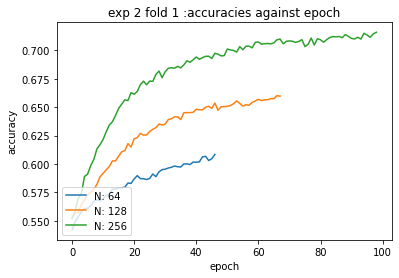

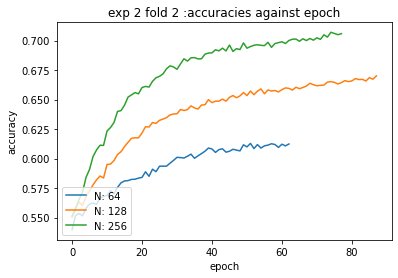

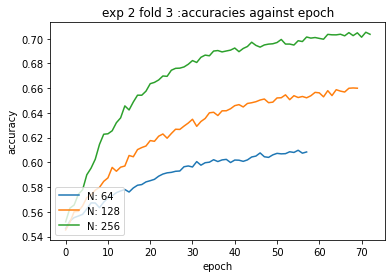

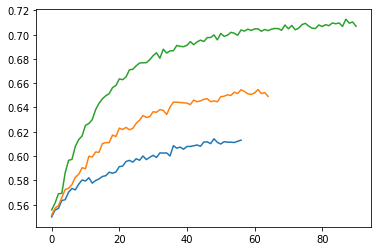

In [ ]:
fold_no=0
exp_no =0

for i in range(len(test_acc)):
    if (i!=0 and i%3==0):
        plt.title("exp %d fold %d :accuracies against epoch"%(exp_no,fold_no))
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['N: 64', 'N: 128','N: 256'], loc='lower left')
        plt.show()
        plt.plot(test_acc[i])
        fold_no = fold_no + 1
        if (fold_no == 5):
            fold_no = 0
            exp_no = exp_no + 1
            
    else:
        plt.plot(test_acc[i])

####**c) Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.**

In [ ]:
l_r = 0.001
epochs = 100
drop_out = 0.2
no_folds = 5
batch_size = 512
num_neurons = 256

In [ ]:
# create the model
model = keras.Sequential([
        Dense(num_neurons, activation='relu'),
        Dropout(drop_out),
        Dense(num_neurons, activation='relu'),
        Dropout(drop_out),
        Dense(num_neurons, activation='relu'),
        Dropout(drop_out),
        Dense(1, activation='sigmoid')])

opt = keras.optimizers.Adam(learning_rate=l_r)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# train the model
history = model.fit(X_train_scaled, Y_train,
                            epochs=epochs,
                            verbose = 2,
                            batch_size=batch_size,
                            callbacks=[callback],
                            validation_data=(X_test_scaled,Y_test))

Epoch 1/100
285/285 - 2s - loss: 0.6884 - binary_accuracy: 0.5437 - val_loss: 0.6827 - val_binary_accuracy: 0.5568 - 2s/epoch - 6ms/step
Epoch 2/100
285/285 - 1s - loss: 0.6800 - binary_accuracy: 0.5602 - val_loss: 0.6776 - val_binary_accuracy: 0.5685 - 937ms/epoch - 3ms/step
Epoch 3/100
285/285 - 1s - loss: 0.6752 - binary_accuracy: 0.5713 - val_loss: 0.6746 - val_binary_accuracy: 0.5726 - 902ms/epoch - 3ms/step
Epoch 4/100
285/285 - 1s - loss: 0.6689 - binary_accuracy: 0.5833 - val_loss: 0.6697 - val_binary_accuracy: 0.5789 - 915ms/epoch - 3ms/step
Epoch 5/100
285/285 - 1s - loss: 0.6628 - binary_accuracy: 0.5913 - val_loss: 0.6618 - val_binary_accuracy: 0.5906 - 899ms/epoch - 3ms/step
Epoch 6/100
285/285 - 1s - loss: 0.6547 - binary_accuracy: 0.6022 - val_loss: 0.6548 - val_binary_accuracy: 0.6027 - 939ms/epoch - 3ms/step
Epoch 7/100
285/285 - 1s - loss: 0.6470 - binary_accuracy: 0.6144 - val_loss: 0.6461 - val_binary_accuracy: 0.6144 - 924ms/epoch - 3ms/step
Epoch 8/100
285/285 - 1

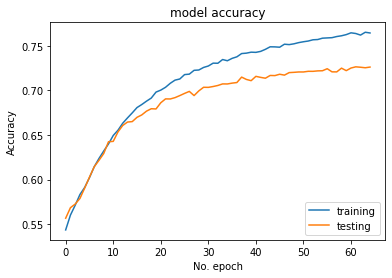

In [ ]:
# plot train and test accuracies curves
plt.plot(history.history['binary_accuracy'], label='training')
plt.plot(history.history['val_binary_accuracy'], label='testing')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.title("model accuracy")
plt.legend(loc="lower right")
plt.show()

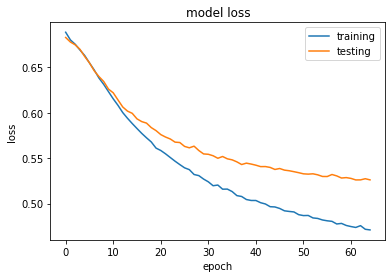

In [ ]:
# plot train and test losses curves
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')    
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("model loss")
plt.legend(loc='best')
plt.show()

From the plots, we can observe significant gaps between training and testing accuracy/loss. It may suggest that the model is overfitting, which mean that it cannot generalize to perform well on the testing dataset. We have deployed the EarlyStopping callback and Dropout layer to avoid overfitting, however, the model still show overfitting pattern.

####**d) How does dropouts work, and what is the purpose of dropouts?**

Dropout works by randomly selecting neurons to be ignored during training but not in testing, or the selected neurons are “dropped out” randomly.
It suggests that their contribution to the activation is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better [2]. This minimizes the redundancy in the network.

####**e) Besides early stopping and dropout, what is another approach that you could take to address overfitting in the model, and how does it work? Implement the approach.**

L2 regularization is an another technique to avoid overfitting. It makes the weights to decay towards zero (but not exactly zero). The L2 loss function will be as following [3]:

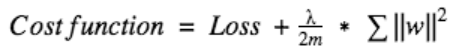


In [ ]:
regularized_model = keras.Sequential([
        Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(drop_out),
        Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(drop_out),
        Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(drop_out),
        Dense(1, activation='sigmoid')])

opt = keras.optimizers.Adam(learning_rate=l_r)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
regularized_model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# train the model
history = regularized_model.fit(X_train_scaled, Y_train,
                            epochs=epochs,
                            verbose = 2,
                            batch_size=batch_size,
                            callbacks=[callback],
                            validation_data=(X_test_scaled,Y_test))

Epoch 1/100
285/285 - 2s - loss: 0.7417 - binary_accuracy: 0.5415 - val_loss: 0.7270 - val_binary_accuracy: 0.5543 - 2s/epoch - 6ms/step
Epoch 2/100
285/285 - 1s - loss: 0.7181 - binary_accuracy: 0.5572 - val_loss: 0.7106 - val_binary_accuracy: 0.5613 - 978ms/epoch - 3ms/step
Epoch 3/100
285/285 - 1s - loss: 0.7038 - binary_accuracy: 0.5691 - val_loss: 0.7010 - val_binary_accuracy: 0.5682 - 937ms/epoch - 3ms/step
Epoch 4/100
285/285 - 1s - loss: 0.6943 - binary_accuracy: 0.5764 - val_loss: 0.6935 - val_binary_accuracy: 0.5713 - 967ms/epoch - 3ms/step
Epoch 5/100
285/285 - 1s - loss: 0.6870 - binary_accuracy: 0.5824 - val_loss: 0.6877 - val_binary_accuracy: 0.5756 - 926ms/epoch - 3ms/step
Epoch 6/100
285/285 - 1s - loss: 0.6802 - binary_accuracy: 0.5931 - val_loss: 0.6802 - val_binary_accuracy: 0.5885 - 942ms/epoch - 3ms/step
Epoch 7/100
285/285 - 1s - loss: 0.6746 - binary_accuracy: 0.5998 - val_loss: 0.6751 - val_binary_accuracy: 0.5989 - 933ms/epoch - 3ms/step
Epoch 8/100
285/285 - 1

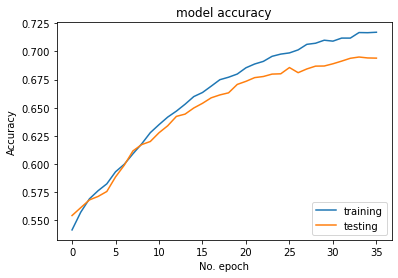

In [ ]:
# plot train and test accuracies curves
plt.plot(history.history['binary_accuracy'], label='training')
plt.plot(history.history['val_binary_accuracy'], label='testing')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.title("model accuracy")
plt.legend(loc="lower right")
plt.show()

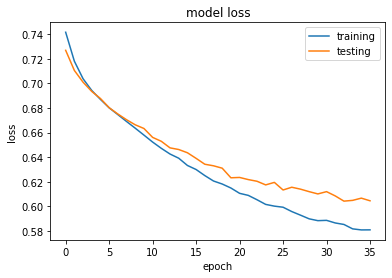

In [ ]:
# plot train and test losses curves
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')    
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("model loss")
plt.legend(loc='best')
plt.show()

It can be seen that the generalization gap is reduced. Althought the gap still increases but adding L2 regularization helps to keep it smaller than the previous part.

# References

[1] https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python

[2] https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras

[3] https://medium.com/unpackai/stay-away-from-overfitting-l2-norm-regularization-weight-decay-and-l1-norm-regularization-795bbc5cf958